## Import packages.

In [1]:
import sys

In [5]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as pl
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.axes as ax
import pandas as pd
import pylab as plt
import numpy as np
import math
import nltk
import string
import spacy
nlp = spacy.load('en_core_web_sm')
import random

import pickle as pickle
import gudhi as gd

from gudhi.representations import *
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from sklearn.manifold import MDS

from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nltk.corpus import brown
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from itertools import count
from itertools import cycle
from pandas import DataFrame
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import LogFormatter
from matplotlib.font_manager import FontProperties
from matplotlib import ticker
from matplotlib import rc
from collections import defaultdict

# Directed graphs documentation: https://networkx.org/documentation/latest/_modules/networkx/classes/digraph.html

## Define *some* initial functions to be used.

### New colormap:

In [8]:
top = cm.get_cmap('summer', 256)
# bottom = cm.get_cmap('autumn_r', 256)
bottom = cm.get_cmap('spring_r', 256)

newcolors = np.vstack((top(np.linspace(0.25, 1, 64)),
                       bottom(np.linspace(0, 0.75, 192))))
newcmp = ListedColormap(newcolors, name='GreenRedish')

### Clean text:

#### *Note: uncomment the nouns row to build other kind of graph.*

In [9]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # tags the words
    text = nltk.pos_tag(text)
    # keeps only the nouns
    text = [word for word, pos in text if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

    return(text)

### Build WordNet graph:

In [10]:
def wordnet_graph(words):    
    """
    Construct a graph where each word is a vertex.
    """   
    graph = nx.DiGraph()
    labels = {}
    seen = set()
    degrees = graph.degree() # nearest neighbour definitions of each word.
    definition_list = set() # collection of individual words used in the definition of other words.
    full_definition = set() # the complete definition of each word.
    
    def recurse(s):
        if not s in seen:
            # adds the word in synset form: "Synset('word.n.01')", to the seen() set.
            seen.add(s)
            # takes synset and transforms into 'word' format.
            sw = s.name().split(".")[0]
            # add a node in the form: 'word', to the graph.
            graph.add_node(sw)
            # returns definition of the synset i.e. using the Synset('word.n.01') format.
            definition = s.definition()
            # clean the text by removing 'stop' words and nouns.
            definition_split = clean_text(definition)
            # adds the full definition of the word to a set.
            full_definition.add(definition)
            
            for d in definition_split:
                # takes all words from the 'defined' list:
                graph.add_node(d)
                graph.add_edge(sw, d)
                definition_list.add(d)
                
                ds = wn.synsets(d)
                
                # Pass statement 
                if len(ds)>0:
                    for i in ds:
                        s2 = wn.synsets(d)[0]
                        recurse(s2)
                    pass
    
    for word in words:
        # takes all synonyms of the word:
        synsets = wn.synsets(word)
        
        for synset in synsets:
            s = wn.synsets(word)[0] ## what would happen if did not take the first one synset?
            recurse(s)
        
    return graph, seen, degrees, definition_list, full_definition

## 2) Take some document off of Brown Corpus:

#### *Text corpora location: http://icame.uib.no/brown/bcm.html#tc, Accessing text corpora: https://www.nltk.org/book/ch02.html.*

In [12]:
text_words = nltk.Text(nltk.corpus.brown.words(fileids=['ca40'])) # TIME magazine - January 13, 1961.

In [13]:
len(text_words)

2340

In [14]:
graph, seen, degrees, definition_list, full_definition = wordnet_graph(text_words)

In [15]:
len(graph)

5062

### Remove self-loops (where a word is used inside the defition of itself) as this can be considered to be redundant:

In [16]:
graph.remove_edges_from(nx.selfloop_edges(graph))

In [17]:
len(graph)

5062

## 3) Find the strongly connected components inside a graph.

### Find SCC's:

In [18]:
nx.number_strongly_connected_components(graph)

4300

In [19]:
S = [graph.subgraph(c).copy() for c in nx.strongly_connected_components(graph)]

In [22]:
GS = []

for ss in range(len(S)):
    if len(S[ss].nodes)>1:
        GS.append(S[ss])

In [23]:
len(GS)

67

In [24]:
GS[0].edges

OutEdgeView([('message', 'communication'), ('information', 'message'), ('communication', 'information')])

In [25]:
def biggest_connected_subgraph(G):
    if G.is_directed():
        components = nx.strongly_connected_components(G)
    biggest = max(components, key=len)
    
    return G.subgraph(biggest)

In [26]:
len(biggest_connected_subgraph(graph))

668

In [27]:
print("Length of text document: ", len(text_words))
print("Number of nodes inside graph: ", len(graph.nodes()))
print("Number of edges inside graph: ", len(graph.edges()))
print("Number of nodes inside SCC: ", len(biggest_connected_subgraph(graph).nodes()))
print("Number of edges inside SCC: ", len(biggest_connected_subgraph(graph).edges()))

Length of text document:  2340
Number of nodes inside graph:  5062
Number of edges inside graph:  11579
Number of nodes inside SCC:  668
Number of edges inside SCC:  1502


### Now select only the largest SCC:

In [28]:
def strongly_connected_component_subgraphs(G, copy=True):
    
    for comp in strongly_connected_components(G):
        if copy:
            yield G.subgraph(comp).copy()
            
        else:
            yield G.subgraph(comp) 

In [29]:
max_Gc = max(nx.strongly_connected_component_subgraphs(graph), key=len)

In [30]:
len(list(max_Gc))

668

## 4) Define distance measures between vertices on graph.

### Create binary matrix using the np.distance_matrix:

In [29]:
from sklearn.neighbors import kneighbors_graph

### Distance matrix:

In [30]:
np_dist_matrix = nx.floyd_warshall_numpy(max_Gc) # numpy distance matrix.

np_binary_matrix = (np_dist_matrix == 1)*float(1) # return binary matrix with 'True' only if nearest neighbour, no self-loops.

binary_array = np.asarray(np_binary_matrix) # returns array.

#### *Number of nodes and edges in the graph:*

In [31]:
n_nodes = graph.number_of_nodes()
n_edges = graph.size()
scc_n_nodes = max_Gc.number_of_nodes()
scc_n_edges = max_Gc.size()

In [32]:
print("Numer of nodes inside WordNet graph: ", n_nodes)
print("Numer of edges inside WordNet graph: ", n_edges)
print("Numer of nodes inside GSCC: ", scc_n_nodes)
print("Numer of edges inside GSCC: ", scc_n_edges)

Numer of nodes inside WordNet graph:  5062
Numer of edges inside WordNet graph:  11579
Numer of nodes inside GSCC:  668
Numer of edges inside GSCC:  1502


### Create a *cycle* function for detection of connected components:

In [33]:
def mcmp(dmatrix):
    mcmp1 = []
    
    
    for T in range(round(len(dmatrix)/20)): # Round to the nearest integer.
        CMP = []
        
        for i in range(len(dmatrix)):
            x = ( np.logical_and( dmatrix[i,:]<T , dmatrix[:,i].transpose()<T ) )*1 # Converts boolean to integer array.
#             x = (dmatrix[i,:]<T)*1 ## , dmatrix.transpose()[:,i]<T ) )*1 # Converts boolean to integer array.
            rowsum = x.sum()
            CMP.append(rowsum)
        
        m1 = max(CMP)
    
        mcmp1.append(m1)
    
    return mcmp1

In [34]:
def mcmp_nplus1(dmatrix):
    mcmp1 = []
    
    
    for T in range(round(len(dmatrix)/20)): # Round to the nearest integer.
        CMP = []
        
        for i in range(len(dmatrix)):
            x = ( np.logical_and( dmatrix[i,:]<(T+1) , dmatrix[:,i].transpose()<(T+1) ) )*1 # Converts boolean to integer array.
#             x = (dmatrix[i,:]<T)*1 ## , dmatrix.transpose()[:,i]<T ) )*1 # Converts boolean to integer array.
            rowsum = x.sum()
            CMP.append(rowsum)
        
        m1 = max(CMP)
    
        mcmp1.append(m1)
    
    return mcmp1

## 5) Configure *onion* loops:

### Create a cycle function for detection of short loops:

In [35]:
def onion(dmatrix, Max_Cycle_Size):
    
    n = Max_Cycle_Size-1
    A = ( dmatrix == 1 )*float(1) # return binary matrix with 'True' only if nearest neighbour, then convert to 0-1 boolean.
    
#     adj = (((np.logical_and(dmatrix<=n, dmatrix.transpose()==1))*1) != np.eye(len(dmatrix)))*1 # logical & NOT identity matrix.
    adj = np.logical_and(dmatrix<=n, dmatrix.transpose()==1)*1
#     adj = np.logical_or(adj==1,adj.transpose()==1)*1
#     adj = np.logical_or(adj,adj.transpose())*1
    
    return adj

In [36]:
adjacency_matrix = onion(np_dist_matrix,5)

In [37]:
onion_graph = nx.from_numpy_matrix(adjacency_matrix, parallel_edges=False, create_using=nx.DiGraph())

## 6) Random rewiring:

### Triangles rewiring:

In [42]:
def find_triangles_on_graph(Graph, itrs):
    
#     1) Ensure numpy matrix is used
#     2) 'rewiring_adjacency_matrix' function takes type 'list' as argument
    
    original_scc = len(max(nx.strongly_connected_component_subgraphs(Graph), key=len))
    adj = nx.to_numpy_matrix(Graph).tolist()
    original_adj = nx.to_numpy_matrix(Graph).tolist()
    edges_list = [e for e in Graph.out_edges]
    edges_list_len = len(edges_list)
    nodes = len(adj)
    counter = 1
    size_scc = []
    triangles = []
    
    while counter <= 10:
        # First edge
        ij_edge = random.randrange(abs(edges_list_len))
        first_edge = [e for e in Graph.out_edges][ij_edge]
#         3) Avoid nodes with no outgoing edges
        i = first_edge[0]
        j = first_edge[1]
        # Second edge
        j_outbound = Graph.out_edges(j)
        if len(j_outbound)==0:
            continue
        jk_edge = random.randrange(abs(len(j_outbound)))
        k = [e for e in j_outbound][jk_edge][1]
        # Third edge
        k_outbound = Graph.out_edges(k)
        if len(k_outbound)==0:
            continue
        ki_edge = random.randrange(abs(len(k_outbound)))
        i_temp = [e for e in k_outbound][ki_edge][1]
        
        if i == i_temp:
            triangles.append([i,j,k])

            counter +=1
            
    print(triangles)

In [43]:
triangles_list = find_triangles_on_graph(max_Gc, 5)

triangles_list

[['money', 'tender', 'payment'], ['venus', 'earth', 'planet'], ['gun', 'barrel', 'bullet'], ['conduit', 'pipe', 'tube'], ['heat', 'temperature', 'hotness'], ['bullet', 'gun', 'barrel'], ['flight', 'aircraft', 'fly'], ['venus', 'earth', 'planet'], ['gun', 'barrel', 'bullet'], ['breathing', 'inhalation', 'air']]


In [44]:
def rewire_triangles_directed_graph(Graph, itrs):
    
#     1) Ensure numpy matrix is used
#     2) 'rewiring_adjacency_matrix' function takes type 'list' as argument
    
    original_scc = len(max(nx.strongly_connected_component_subgraphs(Graph), key=len))
    adj = nx.to_numpy_matrix(Graph).tolist()
    original_adj = nx.to_numpy_matrix(Graph).tolist()
    edges_list = [e for e in Graph.out_edges]
    edges_list_len = len(edges_list)
    nodes_list = np.array(list(Graph.nodes()))
    nodes = len(adj)
    counter = 1
    size_scc = []
    triangles = []
    
    while counter <= 10:
        # First edge
        ij_edge = random.randrange(abs(edges_list_len))
        first_edge = [e for e in Graph.out_edges][ij_edge]
#         3) Avoid nodes with no outgoing edges
        i = first_edge[0]
        j = first_edge[1]
        # Second edge
        j_outbound = Graph.out_edges(j)
        if len(j_outbound)==0:
            continue
        jk_edge = random.randrange(abs(len(j_outbound)))
        k = [e for e in j_outbound][jk_edge][1]
        # Third edge
        k_outbound = Graph.out_edges(k)
        if len(k_outbound)==0:
            continue
        ki_edge = random.randrange(abs(len(k_outbound)))
        i_temp = [e for e in k_outbound][ki_edge][1]
        
        if i == i_temp:
            triangles.append([i,j,k])
            
#         4) Convert label to integer, Networkx=2.3 cannot perform this
        i = np.where(nodes_list == i)[0][0]
        j = np.where(nodes_list == j)[0][0]
        k = np.where(nodes_list == k)[0][0]
        i_temp = np.where(nodes_list == i_temp)[0][0]
            
#         5) Ensures no self-loops are considered
#         6) If edge already exists then find another triangle
        if (i != i_temp or i == j or i == k or j == k or adj[j][i] or adj[k][j] or adj[i][k]
           and not (adj[i][j] or adj[j][k] or adj[k][i])):
            continue
            
        adj_temp = adj # Keep a copy
        adj[j][i], adj[k][j], adj[i][k] = 1, 1, 1
        adj[i][j], adj[j][k], adj[k][i] = 0, 0, 0

        counter +=1
            
    return size_scc, adj, original_adj

### Double edge rewiring:

In [45]:
def double_edgeswap_directed_graph(Graph, adjacency, batch_rewirings, rewirings):
    
#     1) Ensure numpy matrix is used
#     2) 'rewiring_adjacency_matrix' function takes type 'list' as argument
    
    counter = 1
    size_scc = []
    rewired_edges = []
    triangles = []
    original_Graph = Graph.copy()
    original_scc = len(max(nx.strongly_connected_component_subgraphs(Graph), key=len))
    original_adj = nx.to_numpy_matrix(Graph).tolist()
    
    while counter <= rewirings:
        inputGraph = nx.from_numpy_matrix(np.asmatrix(adjacency),create_using=nx.DiGraph)
        scc = len(max(nx.strongly_connected_component_subgraphs(inputGraph), key=len))
        adj_temp = nx.to_numpy_matrix(inputGraph).tolist() # Initialise copy of adjacency matrix
        edges_list = [e for e in inputGraph.out_edges]
        edges_list_len = len(edges_list)
        
        ###################################################################################################
        
        step = batch_rewirings # Initialise a step function
        
        while(step>0):
            ij_edge, kl_edge = random.sample(range(0,abs(edges_list_len)),2)
#             3) Avoid nodes with no outgoing edges
#             First edge
            first_edge = [e for e in inputGraph.out_edges][ij_edge]
            i = first_edge[0]
            j = first_edge[1]
#             Second edge
            second_edge = [e for e in inputGraph.out_edges][kl_edge]
            k = second_edge[0]
            l = second_edge[1]
#             4) Ensures no self-loops are considered
#             5) If edge already exists then find another edge
            if (i == j or i == k or i == l or j == k or j == l or k == l 
                or adj_temp[i][l] or adj_temp[k][j]
                    and not (adj_temp[i][j] or adj_temp[k][l])):
                continue
            
#             6) Ensures no self-loops are considered
#             7) If edge already exists then go find another triangle
            adj_temp[i][l], adj_temp[k][j] = 1, 1
            adj_temp[i][j], adj_temp[k][l] = 0, 0
        
            rewired_edges.append([ij_edge, kl_edge])
        
            step -= 1    
            
        ###################################################################################################
        
#         8) Perform MCMC
        rewired_Graph = nx.from_numpy_matrix(np.asmatrix(adj_temp),create_using=nx.DiGraph)
        rewired_scc = len(max(nx.strongly_connected_component_subgraphs(rewired_Graph), key=len))
        beta = round((100/scc),10)
        
        if rewired_scc > scc: # if new scc is larger
            p_value = np.exp(-beta*(rewired_scc-scc))
            
            if p_value < random.uniform(0, 1): # reject ('continue') approx.99% of the time
                # want to reset
                continue

        size_scc.append(rewired_scc)
        adjacency = adj_temp

        counter +=1
        
    return size_scc

In [46]:
def weighted_MCMC_double_edgeswap_directed_graph(Graph, adjacency, batch_rewirings, rewirings):
    
#     1) Ensure numpy matrix is used
#     2) 'rewiring_adjacency_matrix' function takes type 'list' as argument
    
    counter = 1
    size_scc = []
    rewired_edges = []
    triangles = []
    original_Graph = Graph.copy()
    original_scc = len(max(nx.strongly_connected_component_subgraphs(Graph), key=len))
    original_adj = nx.to_numpy_matrix(Graph).tolist()
    
    while counter <= rewirings:
        inputGraph = nx.from_numpy_matrix(np.asmatrix(adjacency),create_using=nx.DiGraph)
        scc = len(max(nx.strongly_connected_component_subgraphs(inputGraph), key=len))
        adj_temp = nx.to_numpy_matrix(inputGraph).tolist() # Initialise copy of adjacency matrix
        edges_list = [e for e in inputGraph.out_edges]
        edges_list_len = len(edges_list)
        
        ###################################################################################################
        
        step = batch_rewirings # Initialise a step function
        
        while(step>0):
            ij_edge, kl_edge = random.sample(range(0,abs(edges_list_len)),2)
#             3) Avoid nodes with no outgoing edges
#             First edge
            first_edge = [e for e in inputGraph.out_edges][ij_edge]
            i = first_edge[0]
            j = first_edge[1]
#             Second edge
            second_edge = [e for e in inputGraph.out_edges][kl_edge]
            k = second_edge[0]
            l = second_edge[1]
#             4) Ensures no self-loops are considered
#             5) If edge already exists then find another edge
            if (i == j or i == k or i == l or j == k or j == l or k == l 
                or adj_temp[i][l] or adj_temp[k][j]
                    and not (adj_temp[i][j] or adj_temp[k][l])):
                continue
            
#             6) Proportional w.r.t. most popular node
            d_max = sorted(inputGraph.degree, key=lambda x: x[1], reverse=True)[0][0]
            d_i = inputGraph.degree(i)
            d_j = inputGraph.degree(j)
            d_k = inputGraph.degree(k)
            d_l = inputGraph.degree(l)

            if (max(d_i,d_j,d_k,d_l)/d_max) < random.uniform(0,1):
                continue # Want to reset
            
#             7) Ensures no self-loops are considered
#             8) If edge already exists then go find another triangle
            adj_temp[i][l], adj_temp[k][j] = 1, 1
            adj_temp[i][j], adj_temp[k][l] = 0, 0
        
            rewired_edges.append([ij_edge, kl_edge])
        
            step -= 1    
            
        ###################################################################################################
        
#         9) Perform MCMC
        rewired_Graph = nx.from_numpy_matrix(np.asmatrix(adj_temp),create_using=nx.DiGraph)
        rewired_scc = len(max(nx.strongly_connected_component_subgraphs(rewired_Graph), key=len))
        beta = round((100/scc),10)
        
        if rewired_scc > scc: # if new scc is larger
            p_value = np.exp(-beta*(rewired_scc-scc))
            
            if p_value < random.uniform(0, 1): # reject ('continue') approx.99% of the time
                # want to reset
                continue

        size_scc.append(rewired_scc)
        adjacency = adj_temp

        counter +=1
        
    return size_scc

In [47]:
size_scc = weighted_MCMC_double_edgeswap_directed_graph(graph, nx.to_numpy_matrix(graph).tolist(), 5, 1)

size_scc

[668]

In [48]:
def stepped_weighted_MCMC_double_edgeswap_triangles(Graph, adjacency, batch_rewirings, rewirings):
    
#     1) Ensure numpy matrix is used
#     2) 'rewiring_adjacency_matrix' function takes type 'list' as argument
    
    counter = 1
    size_scc = []
    rewired_edges = []
    triangles = []
    original_Graph = Graph.copy()
    original_scc = len(max(nx.strongly_connected_component_subgraphs(Graph), key=len))
    original_adj = nx.to_numpy_matrix(Graph).tolist()
    
    while counter <= rewirings:
        inputGraph = nx.from_numpy_matrix(np.asmatrix(adjacency),create_using=nx.DiGraph)
        scc = len(max(nx.strongly_connected_component_subgraphs(inputGraph), key=len))
        adj_temp = nx.to_numpy_matrix(inputGraph).tolist() # Initialise copy of adjacency matrix
        edges_list = [e for e in inputGraph.out_edges]
        edges_list_len = len(edges_list)
        
        ###################################################################################################
        
        step = batch_rewirings # Initialise a step function
        
        while(step>0):
            if 0.005 < random.uniform(0,1):
#                 First edge
                ij_edge = random.randrange(abs(edges_list_len))
                first_edge = [e for e in inputGraph.out_edges][ij_edge]
#                 3) Avoid nodes with no outgoing edges
                i = first_edge[0]
                j = first_edge[1]
#                 Second edge
                j_outbound = inputGraph.out_edges(j)
                if len(j_outbound)==0:
                    continue
                jk_edge = random.randrange(abs(len(j_outbound)))
                k = [e for e in j_outbound][jk_edge][1]
#                 Third edge
                k_outbound = inputGraph.out_edges(k)
                if len(k_outbound)==0:
                    continue
                ki_edge = random.randrange(abs(len(k_outbound)))
                i_temp = [e for e in k_outbound][ki_edge][1]
            
#                 4) Ensures no self-loops are considered
#                 5) If edge already exists then find another triangle
                if (i != i_temp or i == j or i == k or j == k or adj_temp[j][i] or adj_temp[k][j] or adj_temp[i][k]
                   and not (adj_temp[i][j] or adj_temp[j][k] or adj_temp[k][i])):
                    continue
                
                adj_temp[j][i], adj_temp[k][j], adj_temp[i][k] = 1, 1, 1
                adj_temp[i][j], adj_temp[j][k], adj_temp[k][i] = 0, 0, 0
                
                if i == i_temp:
                    triangles.append([i,j,k])
                
            ##############################################################################
            else:
                ij_edge, kl_edge = random.sample(range(0,abs(edges_list_len)),2)
#                 3) Avoid nodes with no outgoing edges
#                 First edge
                first_edge = [e for e in inputGraph.out_edges][ij_edge]
                i = first_edge[0]
                j = first_edge[1]
#                 Second edge
                second_edge = [e for e in inputGraph.out_edges][kl_edge]
                k = second_edge[0]
                l = second_edge[1]
#                 4) Ensures no self-loops are considered
#                 5) If edge already exists then find another edge
                if (i == j or i == k or i == l or j == k or j == l or k == l 
                    or adj_temp[i][l] or adj_temp[k][j]
                        and not (adj_temp[i][j] or adj_temp[k][l])):
                    continue
            
#                 6) Proportional w.r.t. most popular node
                d_max = sorted(inputGraph.degree, key=lambda x: x[1], reverse=True)[0][0]
                d_i = inputGraph.degree(i)
                d_j = inputGraph.degree(j)
                d_k = inputGraph.degree(k)
                d_l = inputGraph.degree(l)

                if (max(d_i,d_j,d_k,d_l)/d_max) < random.uniform(0,1):
                    continue # Want to reset
            
#                 7) Ensures no self-loops are considered
#                 8) If edge already exists then go find another triangle
                adj_temp[i][l], adj_temp[k][j] = 1, 1
                adj_temp[i][j], adj_temp[k][l] = 0, 0
        
                rewired_edges.append([ij_edge, kl_edge])
            ##############################################################################
        
            step -= 1    
            
        ###################################################################################################
        
#         9) Perform MCMC
        rewired_Graph = nx.from_numpy_matrix(np.asmatrix(adj_temp),create_using=nx.DiGraph)
        rewired_scc = len(max(nx.strongly_connected_component_subgraphs(rewired_Graph), key=len))
        beta = round((100/scc),10)
        
        if rewired_scc > scc: # if new scc is larger
            p_value = np.exp(-beta*(rewired_scc-scc))
            
            if p_value < random.uniform(0, 1): # reject ('continue') approx.99% of the time
                # want to reset
                continue

        size_scc.append(rewired_scc)
        adjacency = adj_temp

        counter +=1
        
    return size_scc

In [49]:
size_scc = stepped_weighted_MCMC_double_edgeswap_triangles(graph, nx.to_numpy_matrix(graph).tolist(), 5, 10)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


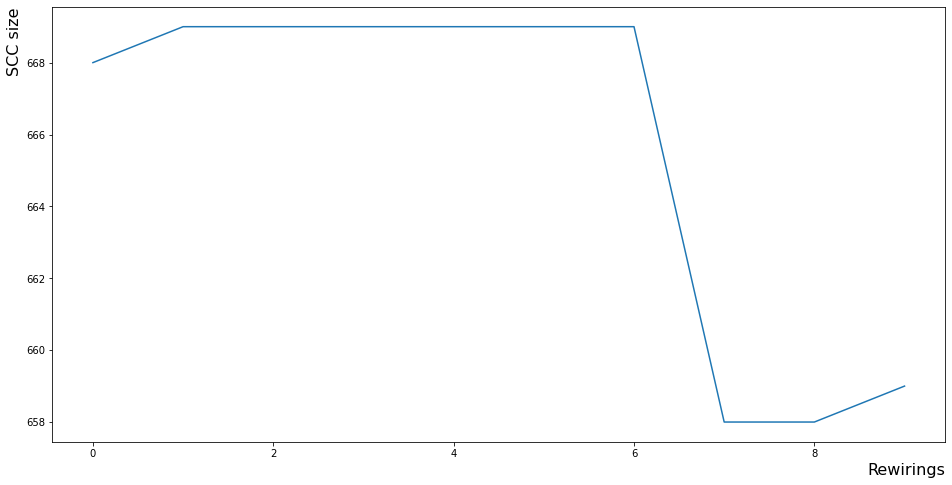

In [50]:
fig = plt.figure(figsize=(16, 8))

plt.plot(size_scc)

plt.xlabel('Rewirings', size=16, loc='right')
plt.ylabel('SCC size', size=16, loc='top')
plt.show()

fig.savefig('language_graph_stepped_weighted_SizeSCC.png', bbox_inches="tight")

### Initialise number of rewirings to take place:

In [51]:
edgeRewirings = 100
stepRewirings = 20

In [52]:
languageGraphs = []
for lgi in range(0,10):
    languageGraphs.append(graph.copy())

In [53]:
languageAdjacency = []
for lai in range(len(languageGraphs)):
    languageAdjacency.append(nx.to_numpy_matrix(languageGraphs[lai]))

In [54]:
languageRewiring = []
for lri in range(len(languageGraphs)):
    languageRewiring.append( double_edgeswap_directed_graph(languageGraphs[lri], languageAdjacency[lri], stepRewirings, edgeRewirings) )

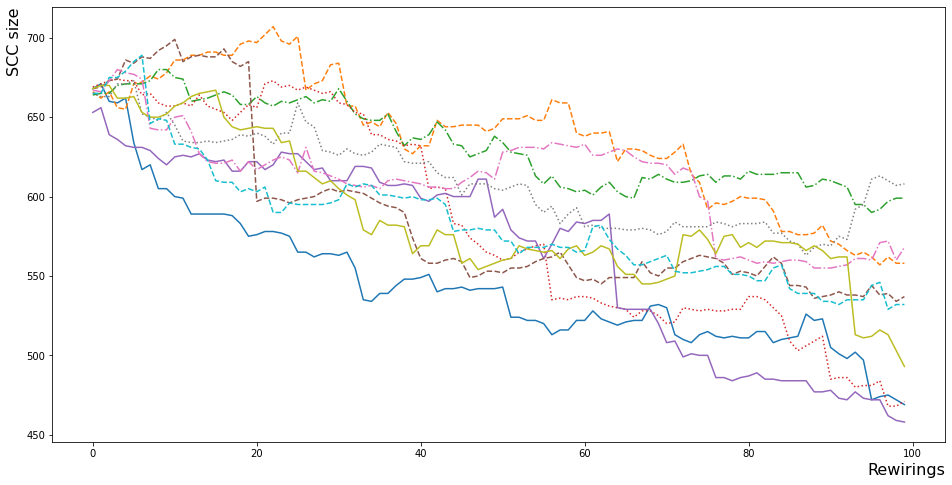

In [118]:
lines = ["-","--","-.",":"]
linecycles = cycle(lines)

fig = plt.figure(figsize=(16, 8))

for language in languageRewiring:
    plt.plot(language, next(linecycles))
    
plt.xlabel('Rewirings', size=16, loc='right')
plt.ylabel('SCC size', size=16, loc='top')
plt.show()

fig.savefig('language_graphs_double_edge_SizeSCC.png', bbox_inches="tight")

In [56]:
weightedLanguageRewiring = []
for lri in range(len(languageGraphs)):
    weightedLanguageRewiring.append( weighted_MCMC_double_edgeswap_directed_graph(languageGraphs[lri], languageAdjacency[lri], stepRewirings, edgeRewirings) )

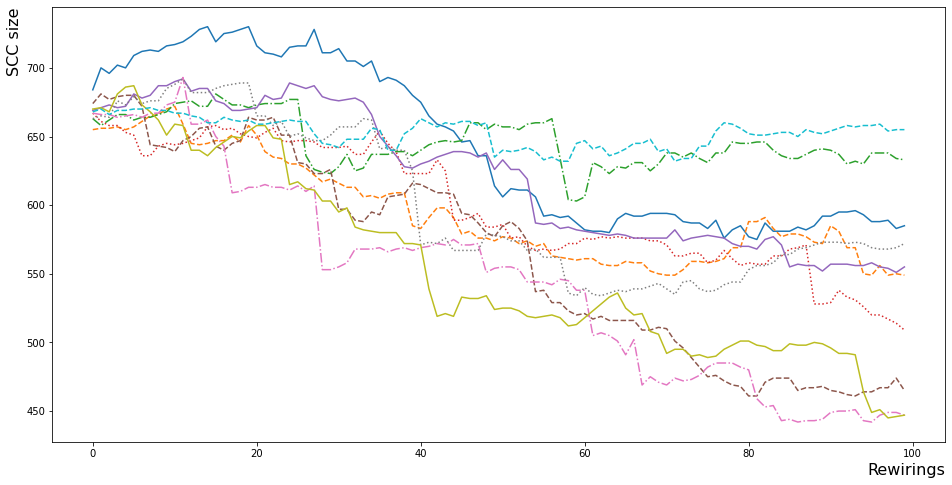

In [57]:
lines = ["-","--","-.",":"]
linecycles = cycle(lines)

fig = plt.figure(figsize=(16, 8))

for language in weightedLanguageRewiring:
    plt.plot(language, next(linecycles))
    
plt.xlabel('Rewirings', size=16, loc='right')
plt.ylabel('SCC size', size=16, loc='top')
plt.show()

fig.savefig('language_graphs_weighted_double_edge_SizeSCC.png', bbox_inches="tight")

In [58]:
detLanguageRewiring = []
for lri in range(len(languageGraphs)):
    detLanguageRewiring.append( stepped_weighted_MCMC_double_edgeswap_triangles(languageGraphs[lri], languageAdjacency[lri], stepRewirings, edgeRewirings) )

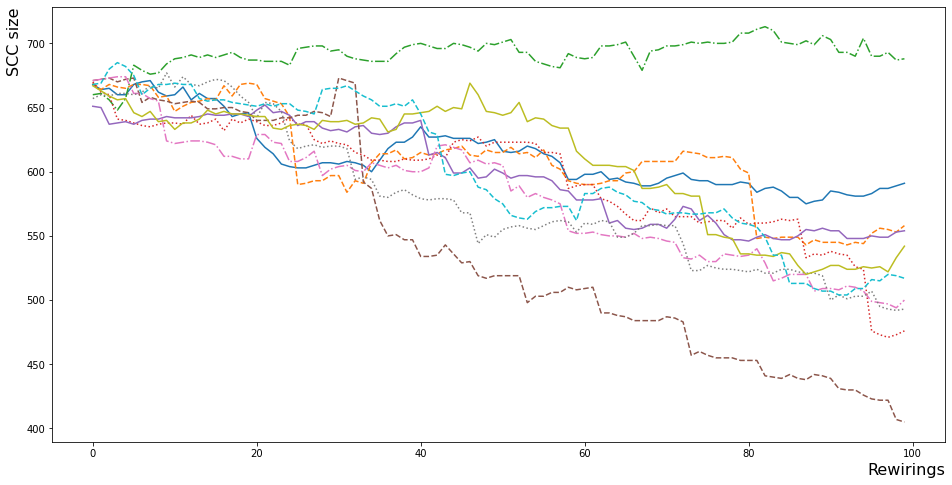

In [59]:
lines = ["-","--","-.",":"]
linecycles = cycle(lines)

fig = plt.figure(figsize=(16, 8))

for language in detLanguageRewiring:
    plt.plot(language, next(linecycles))
    
plt.xlabel('Rewirings', size=16, loc='right')
plt.ylabel('SCC size', size=16, loc='top')
plt.show()

fig.savefig('language_graphs_stepped_weighted_double_edge_triangle_SizeSCC.png', bbox_inches="tight")

### Synthesise graphs:

In [72]:
edgeRewirings = 1000
stepRewirings = 20

In [73]:
dinGraph = list(d for n,d in graph.in_degree())

doutGraph = list(d for n,d in graph.out_degree())

configGraph = nx.directed_configuration_model(dinGraph, doutGraph, create_using=nx.DiGraph(), seed=None)

In [74]:
len(configGraph)

5062

In [75]:
randomGraphs = []
for gi in range(0,10):
    randomGraphs.append(nx.directed_configuration_model(dinGraph, doutGraph, create_using = nx.DiGraph(), seed=None))

In [76]:
randomAdjacency = []
for rgi in range(len(randomGraphs)):
    randomAdjacency.append(nx.to_numpy_matrix(randomGraphs[rgi]))

#### *Double-edge rewiring:*

In [77]:
randomRewiring = []
for lri in range(len(randomGraphs)):
    randomRewiring.append( double_edgeswap_directed_graph(randomGraphs[lri], randomAdjacency[lri], stepRewirings, edgeRewirings) )

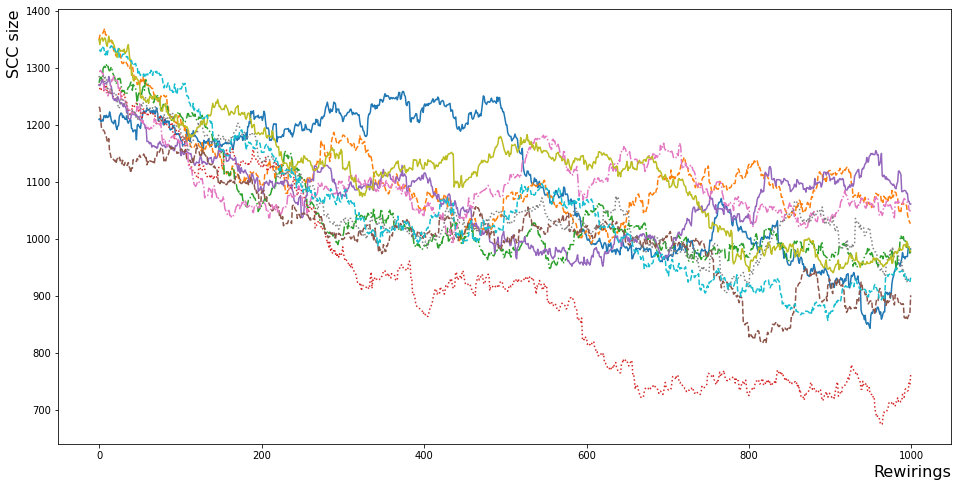

In [78]:
lines = ["-","--","-.",":"]
linecycles = cycle(lines)

fig = plt.figure(figsize=(16, 8))

for rewire in randomRewiring:
    plt.plot(rewire, next(linecycles))
    
plt.xlabel('Rewirings', size=16, loc='right')
plt.ylabel('SCC size', size=16, loc='top')
plt.show()

fig.savefig('random_graphs_double_edge_SizeSCC.png', bbox_inches="tight")

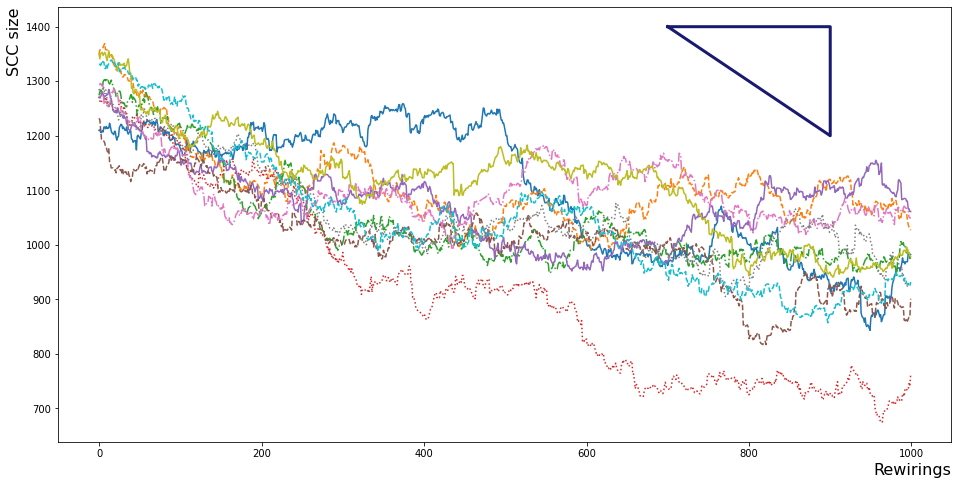

In [142]:
lines = ["-","--","-.",":"]
linecycles = cycle(lines)

fig = plt.figure(figsize=(16, 8))

for language in rand1:
    plt.plot(language, next(linecycles))
    
slopex = np.array([700, 900, 900, 700])
slopey = np.array([1400, 1400, 1200, 1400])
plt.plot(slopex, slopey, linewidth = '3', c = 'midnightblue')
    
plt.xlabel('Rewirings', size=16, loc='right')
plt.ylabel('SCC size', size=16, loc='top')
plt.show()

fig.savefig('random_graphs_de_SizeSCC.png', bbox_inches="tight")

#### *Weighted double-edge rewiring:*

In [79]:
weightedRandomRewiring = []
for lri in range(len(randomGraphs)):
    weightedRandomRewiring.append( weighted_MCMC_double_edgeswap_directed_graph(randomGraphs[lri], randomAdjacency[lri], stepRewirings, edgeRewirings) )

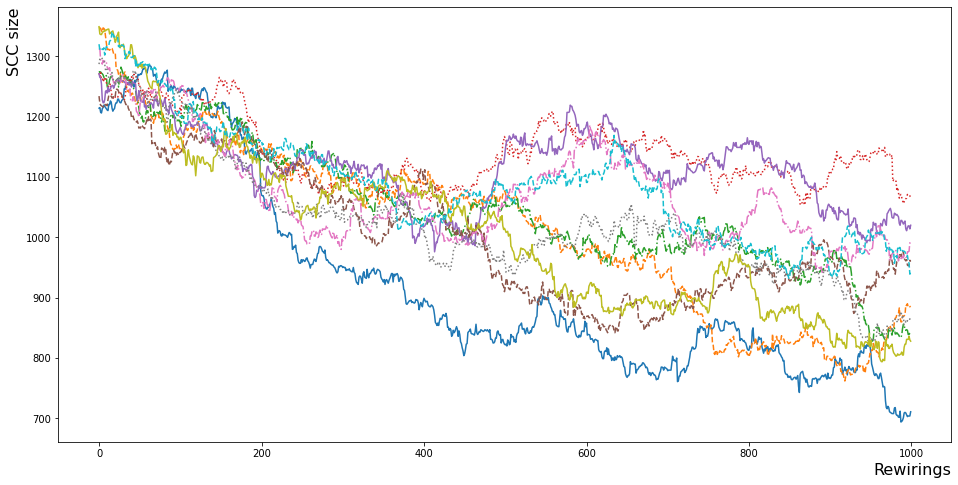

In [80]:
lines = ["-","--","-.",":"]
linecycles = cycle(lines)

fig = plt.figure(figsize=(16, 8))

for rewire in weightedRandomRewiring:
    plt.plot(rewire, next(linecycles))
    
plt.xlabel('Rewirings', size=16, loc='right')
plt.ylabel('SCC size', size=16, loc='top')
plt.show()

fig.savefig('random_graphs_weighted_double_edge_SizeSCC.png', bbox_inches="tight")

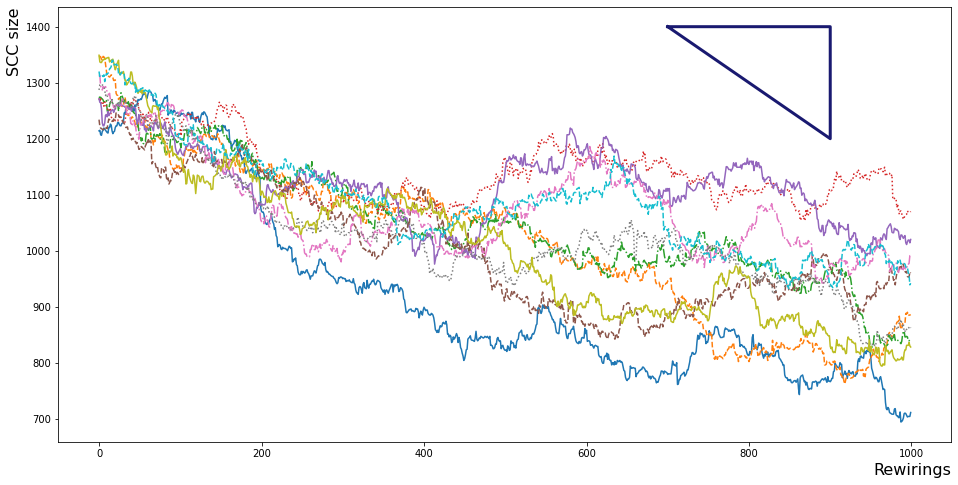

In [143]:
lines = ["-","--","-.",":"]
linecycles = cycle(lines)

fig = plt.figure(figsize=(16, 8))

for language in rand2:
    plt.plot(language, next(linecycles))
    
slopex = np.array([700, 900, 900, 700])
slopey = np.array([1400, 1400, 1200, 1400])
plt.plot(slopex, slopey, linewidth = '3', c = 'midnightblue')
    
plt.xlabel('Rewirings', size=16, loc='right')
plt.ylabel('SCC size', size=16, loc='top')
plt.show()

fig.savefig('random_graphs_wde_SizeSCC.png', bbox_inches="tight")

#### *Weighted double-edge and triangle rewiring:*

In [81]:
detRandomRewiring = []
for rgi in range(len(randomGraphs)):
    detRandomRewiring.append( stepped_weighted_MCMC_double_edgeswap_triangles(randomGraphs[rgi], randomAdjacency[rgi], stepRewirings, edgeRewirings) )

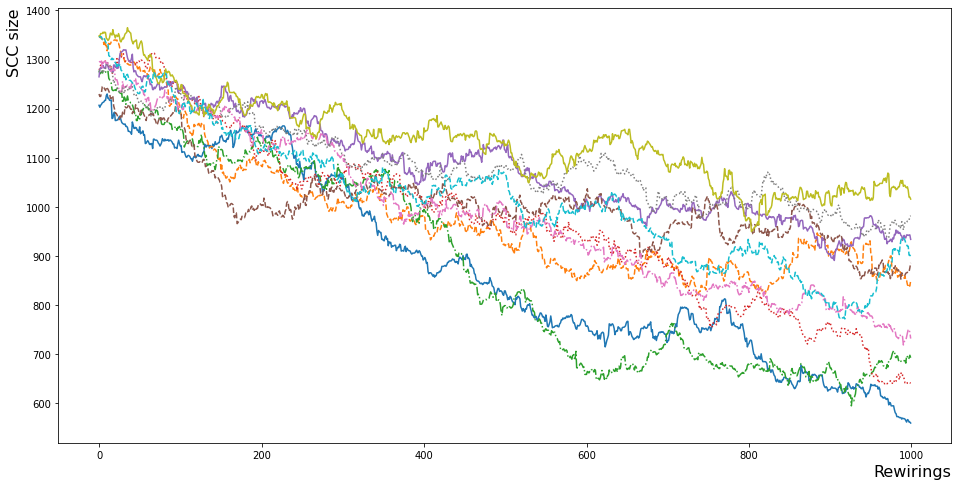

In [83]:
lines = ["-","--","-.",":"]
linecycles = cycle(lines)

fig = plt.figure(figsize=(16, 8))

for rewire in detRandomRewiring:
    plt.plot(rewire, next(linecycles))
    
plt.xlabel('Rewirings', size=16, loc='right')
plt.ylabel('SCC size', size=16, loc='top')
plt.show()

fig.savefig('random_graphs_stepped_weighted_double_edge_triangle_SizeSCC.png', bbox_inches="tight")

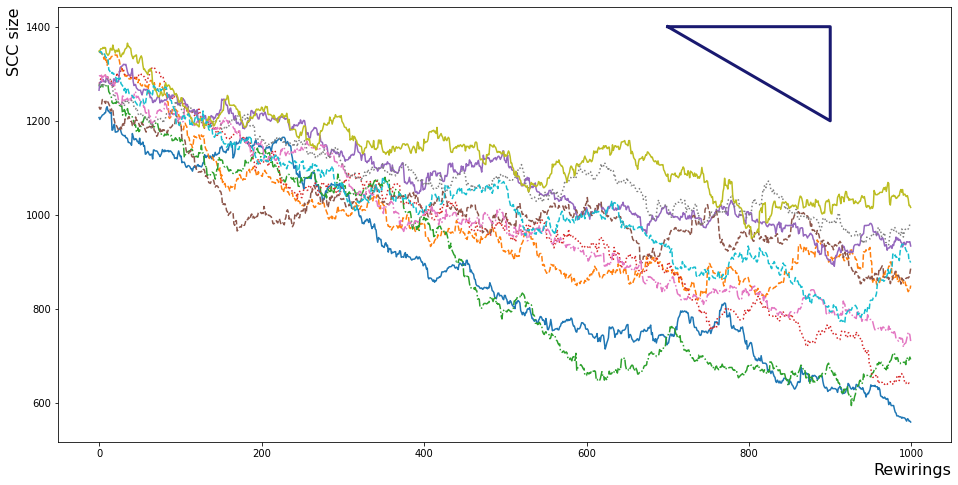

In [144]:
lines = ["-","--","-.",":"]
linecycles = cycle(lines)

fig = plt.figure(figsize=(16, 8))

for language in rand3:
    plt.plot(language, next(linecycles))
    
slopex = np.array([700, 900, 900, 700])
slopey = np.array([1400, 1400, 1200, 1400])
plt.plot(slopex, slopey, linewidth = '3', c = 'midnightblue')
    
plt.xlabel('Rewirings', size=16, loc='right')
plt.ylabel('SCC size', size=16, loc='top')
plt.show()

fig.savefig('random_graphs_det_SizeSCC.png', bbox_inches="tight")